In [1]:
import copy
import os, sys
#from nflows import transforms, distributions, flows
import torch
from scipy.special import logsumexp
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import entropy

from torch import nn
from torch import optim
import torch.distributions as D
import emcee
import corner
import time
from multiprocessing import cpu_count, Pool

import os
import h5py 
import numpy as np
# import fitsio
# from tqdm.auto import trange
import astropy.table as aTable
from astropy.cosmology import Planck13
from astropy.cosmology import FlatLambdaCDM

import sys

import numpy as np
from matplotlib import pyplot as plt


sys.path.append('../')

from BGS import BGS
from HST import HST
from COSMOS import COSMOS

from FileEmcee import FileEmcee
from EmceeRun import EmceeRun

from Plotter import Plotter
from PlotterHst import PlotterHst
from PlotterCOSMOS import PlotterCOSMOS

from VMaxDensity import VmaxDensity
from VMaxDensityHst import VmaxDensityHst

from ZSchechterModel import ZSchechterModel
from NoZSchechterModel import NoZSchechterModel

from Fileh5 import Fileh5

In [2]:
def mass_completeness_limit_bgs(z):
    x_values = np.load('z_limit_bright.npy')
    y_values = np.load('mass_limit_bright.npy')
    
    f = interp1d(x_values, y_values, fill_value='extrapolate')
    return f(z)


def fit_schechter(x, logM, alpha1, logPhi):
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return 10**logPhi * term0 * term1


def smf_single_schechter_sty(x, z, a0, a1, a2, a3):
    logM = a0 + a1*z
    alpha1 = a2 + a3*z
    term0 = np.exp(-10 ** (x-logM))
    term1 = 10 ** ((alpha1+1)*(x - logM))
    return term0 * term1


def plot_zschechter_single(x, z0, norm, best_params, **plot_params):
    a0, a1, a2, a3 = best_params
    zschechter = smf_single_schechter_sty(x, z0, a0, a1, a2, a3)
    plt.plot(x, norm * zschechter, **plot_params)

    plt.yscale('log')
    plt.ylim(1e-5, 4e-2)
    plt.xlim(6, 13)

    plt.xlabel(r'$\log M_*$', fontsize=15)
    plt.ylabel(r'$p(\log M_*)$ [$({\rm Mpc}/h)^{-3}{\rm dex}^{-1}$]', fontsize=15)


def normalisation_single(z0, zmin, zmax, x_median_bgs, z_bgs, best_params):
    a0, a1, a2, a3 = best_params
    # v_zmin = Planck13.comoving_volume(zmin).value # (Mpc/h)^3
    # v_zmax = Planck13.comoving_volume(zmax).value # (Mpc/h)^3

    vzmin_bgs = Planck13.comoving_volume(zmin).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))  # (Mpc/h)^3
    vzmax_bgs = Planck13.comoving_volume(zmax).value * Planck13.h ** 3 * (173.641 / (4. * np.pi * (180 / np.pi) ** 2))
    
    m_max = 13
    m_min = 6.
    nbin = 40
    bin_size = (m_max - m_min) / nbin
    # x_median_bgs = x
    # z_bgs, z_cosmos, z_hst = z

    x_bgs_bin = x_median_bgs[(z_bgs > zmin) & (z_bgs < zmax)]

    z_bgs_bin = z_bgs[(z_bgs > zmin) & (z_bgs < zmax)]

    I_bgs = [integrate.quad(smf_single_schechter_sty, mass_completeness_limit_bgs(z_bgs_bin)[i], 13., 
                            args=(z0, a0, a1, a2, a3))[0] for i in range(z_bgs_bin.shape[0])]

    
    N_bgs = bin_size / (vzmax_bgs - vzmin_bgs) * np.sum((1.) / np.array(I_bgs))
    
    return N_bgs

In [3]:
def select_galaxies(bgs, zmin, zmax, field):
    """Return z, x, x_median, w_spec, vmax for galaxies between (zmin,zmax)"""
    mask_zlim = (bgs.z > zmin) & (bgs.z < zmax) & (bgs.x_median > mass_completeness_limit_bgs(bgs.z)) & ~field

    v_zmin = Planck13.comoving_volume(zmin).value * Planck13.h ** 3 * bgs.f_area  # (Mpc/h)^3
    v_zmax = Planck13.comoving_volume(zmax).value * Planck13.h ** 3 * bgs.f_area  # (Mpc/h)^3

    z = bgs.z[mask_zlim]
    x = bgs.x[mask_zlim]
    x_median = bgs.x_median[mask_zlim]
    w_zfail = bgs.w_zfail[mask_zlim]
    w_fib = bgs.w_fib[mask_zlim]
    w_spec = w_fib * w_zfail
    vmax = (bgs.vmax.clip(v_zmin, v_zmax) - v_zmin)[mask_zlim]

    return z, x, x_median, w_spec, vmax

In [4]:
bgs = BGS('BGS_ANY_full.provabgs.lite.hdf5')

In [5]:
# bgs = aTable.Table.read(os.path.join('../data/', 'BGS_ANY_full.provabgs.lite.hdf5'))
# bgs = bgs[bgs['is_bgs_bright']]

## Jack Knife

In [6]:
fields = [
    ((bgs.ra > 140) & (bgs.ra < 160)), 
    ((bgs.ra > 160) & (bgs.ra < 185) & (bgs.dec > -10) & (bgs.dec < 10)), 
    ((bgs.ra > 205) & (bgs.ra < 212) & (bgs.dec > 2) & (bgs.dec < 8)), 
    ((bgs.ra > 210) & (bgs.ra < 224) & (bgs.dec > -5) & (bgs.dec < 5) & ~((bgs.ra > 205) & (bgs.ra < 212) & (bgs.dec > 2) & (bgs.dec < 8))),
    ((bgs.ra > 190) & (bgs.ra < 200) & (bgs.dec > 20) & (bgs.dec < 30)), 
    ((bgs.ra > 210) & (bgs.ra < 225) & (bgs.dec > 30) & (bgs.dec < 40)),     
    ((bgs.ra > 250) & (bgs.ra < 260) & (bgs.dec > 30) & (bgs.dec < 40)),
    ((bgs.ra > 230) & (bgs.ra < 255) & (bgs.dec > 40) & (bgs.dec < 45)),    
    ((bgs.ra > 210) & (bgs.ra < 225) & (bgs.dec > 45) & (bgs.dec < 58)),        
    ((bgs.ra > 235) & (bgs.ra < 255) & (bgs.dec > 50) & (bgs.dec < 60)), 
    ((bgs.ra > 180) & (bgs.ra < 200) & (bgs.dec > 55) & (bgs.dec < 70)), 
    ((bgs.ra > 260) & (bgs.ra < 280) & (bgs.dec > 55) & (bgs.dec < 70))    
]

A_fields = [164.965, 156.064, 164.917, 138.785, 155.972, 164.848, 165.120, 148.024, 
            165.015, 165.030, 164.890, 156.806]

In [7]:
zmins = np.array([0.01 + 0.04 * i for i in range(7)])
zmaxs = np.array([0.05 + 0.04 * i for i in range(7)])

In [8]:
h_tot = []
sig_jack_tot = []

vmax_hist = VmaxDensity(bgs.file, is_bgs_bright=True)

for zmin, zmax in zip(zmins, zmaxs):
    h, b, _h, _b = vmax_hist.histogram_norm(zmin, zmax)
    h_tot.append(h)
    h_jack = []
    for field, A_field in zip(fields, A_fields):
        z, x, x_median, w_spec, vmax = select_galaxies(bgs, zmin, zmax, field)
        weights = (w_spec / vmax)
        hist, bin_edges = np.histogram(x_median, bins=40, range=(6., 13.), weights=weights)
        h_jack.append(hist)
    
    h_jack = np.array(h_jack)
    sig_jack = np.sqrt(float(len(fields)-1)/float(len(fields)) * np.sum((h_jack - np.mean(h_jack, axis=0))**2, axis=0))
    
    sig_jack_tot.append(sig_jack)

/Users/federico/Library/CloudStorage/OneDrive-UniversityCollegeLondon/PhD/PhD_project/bgs_psmf/nb/../VMaxDensity.py:19: RuntimeWarning: divide by zero encountered in divide
  _w = self.w_spec / (self.vmax.clip(v_zmin, v_zmax) - v_zmin)


In [9]:
sig_jack_tot = np.array(sig_jack_tot)
h_tot = np.array(h_tot)

In [10]:
sig_jack_tot.shape, h_tot.shape

((7, 40), (7, 40))

In [11]:
import emcee

def log_likelihood(theta, x, y, yerr):
    logM, alpha1, logPhi = theta
    model = fit_schechter(x, logM, alpha1, logPhi)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2)



def log_prior(theta):
    logM, alpha1, phi = theta
    if 9.5 < logM < 12. and -4. < alpha1 < .0 and -4 < phi < -1:
        return 0.0
    return -np.inf



def posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)



def run_emcee(x, y, yerr, ex, guess, sampler_list, flat_samples_list):
    
    pos = guess + 1e-4 * np.random.randn(50, 3)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, posterior, args=(x[ex:], y[ex:], yerr[ex:])
    )
    sampler.run_mcmc(pos, 600, progress=True);
    flat_samples = sampler.get_chain(discard=230, thin=15, flat=True)
    
    sampler_list.append(sampler)
    flat_samples_list.append(flat_samples)
    

    mcmc = np.array([np.percentile(flat_samples[:, i], [16, 50, 84]) for i in range(ndim)])
    return mcmc[:,1]

In [12]:
emcee_file = Fileh5(folder='emcee_runs', info_file='_single_')
emcee_run = EmceeRun(emcee_file)

emcee_run.set_best_params(discard=230)
best_params = emcee_run.get_best_params()
a0, a1, a2, a3 = best_params
logPhi_p = -2.523920246269251

100%|█████████████████████████████████████████████████| 600/600 [00:00<00:00, 1681.02it/s]


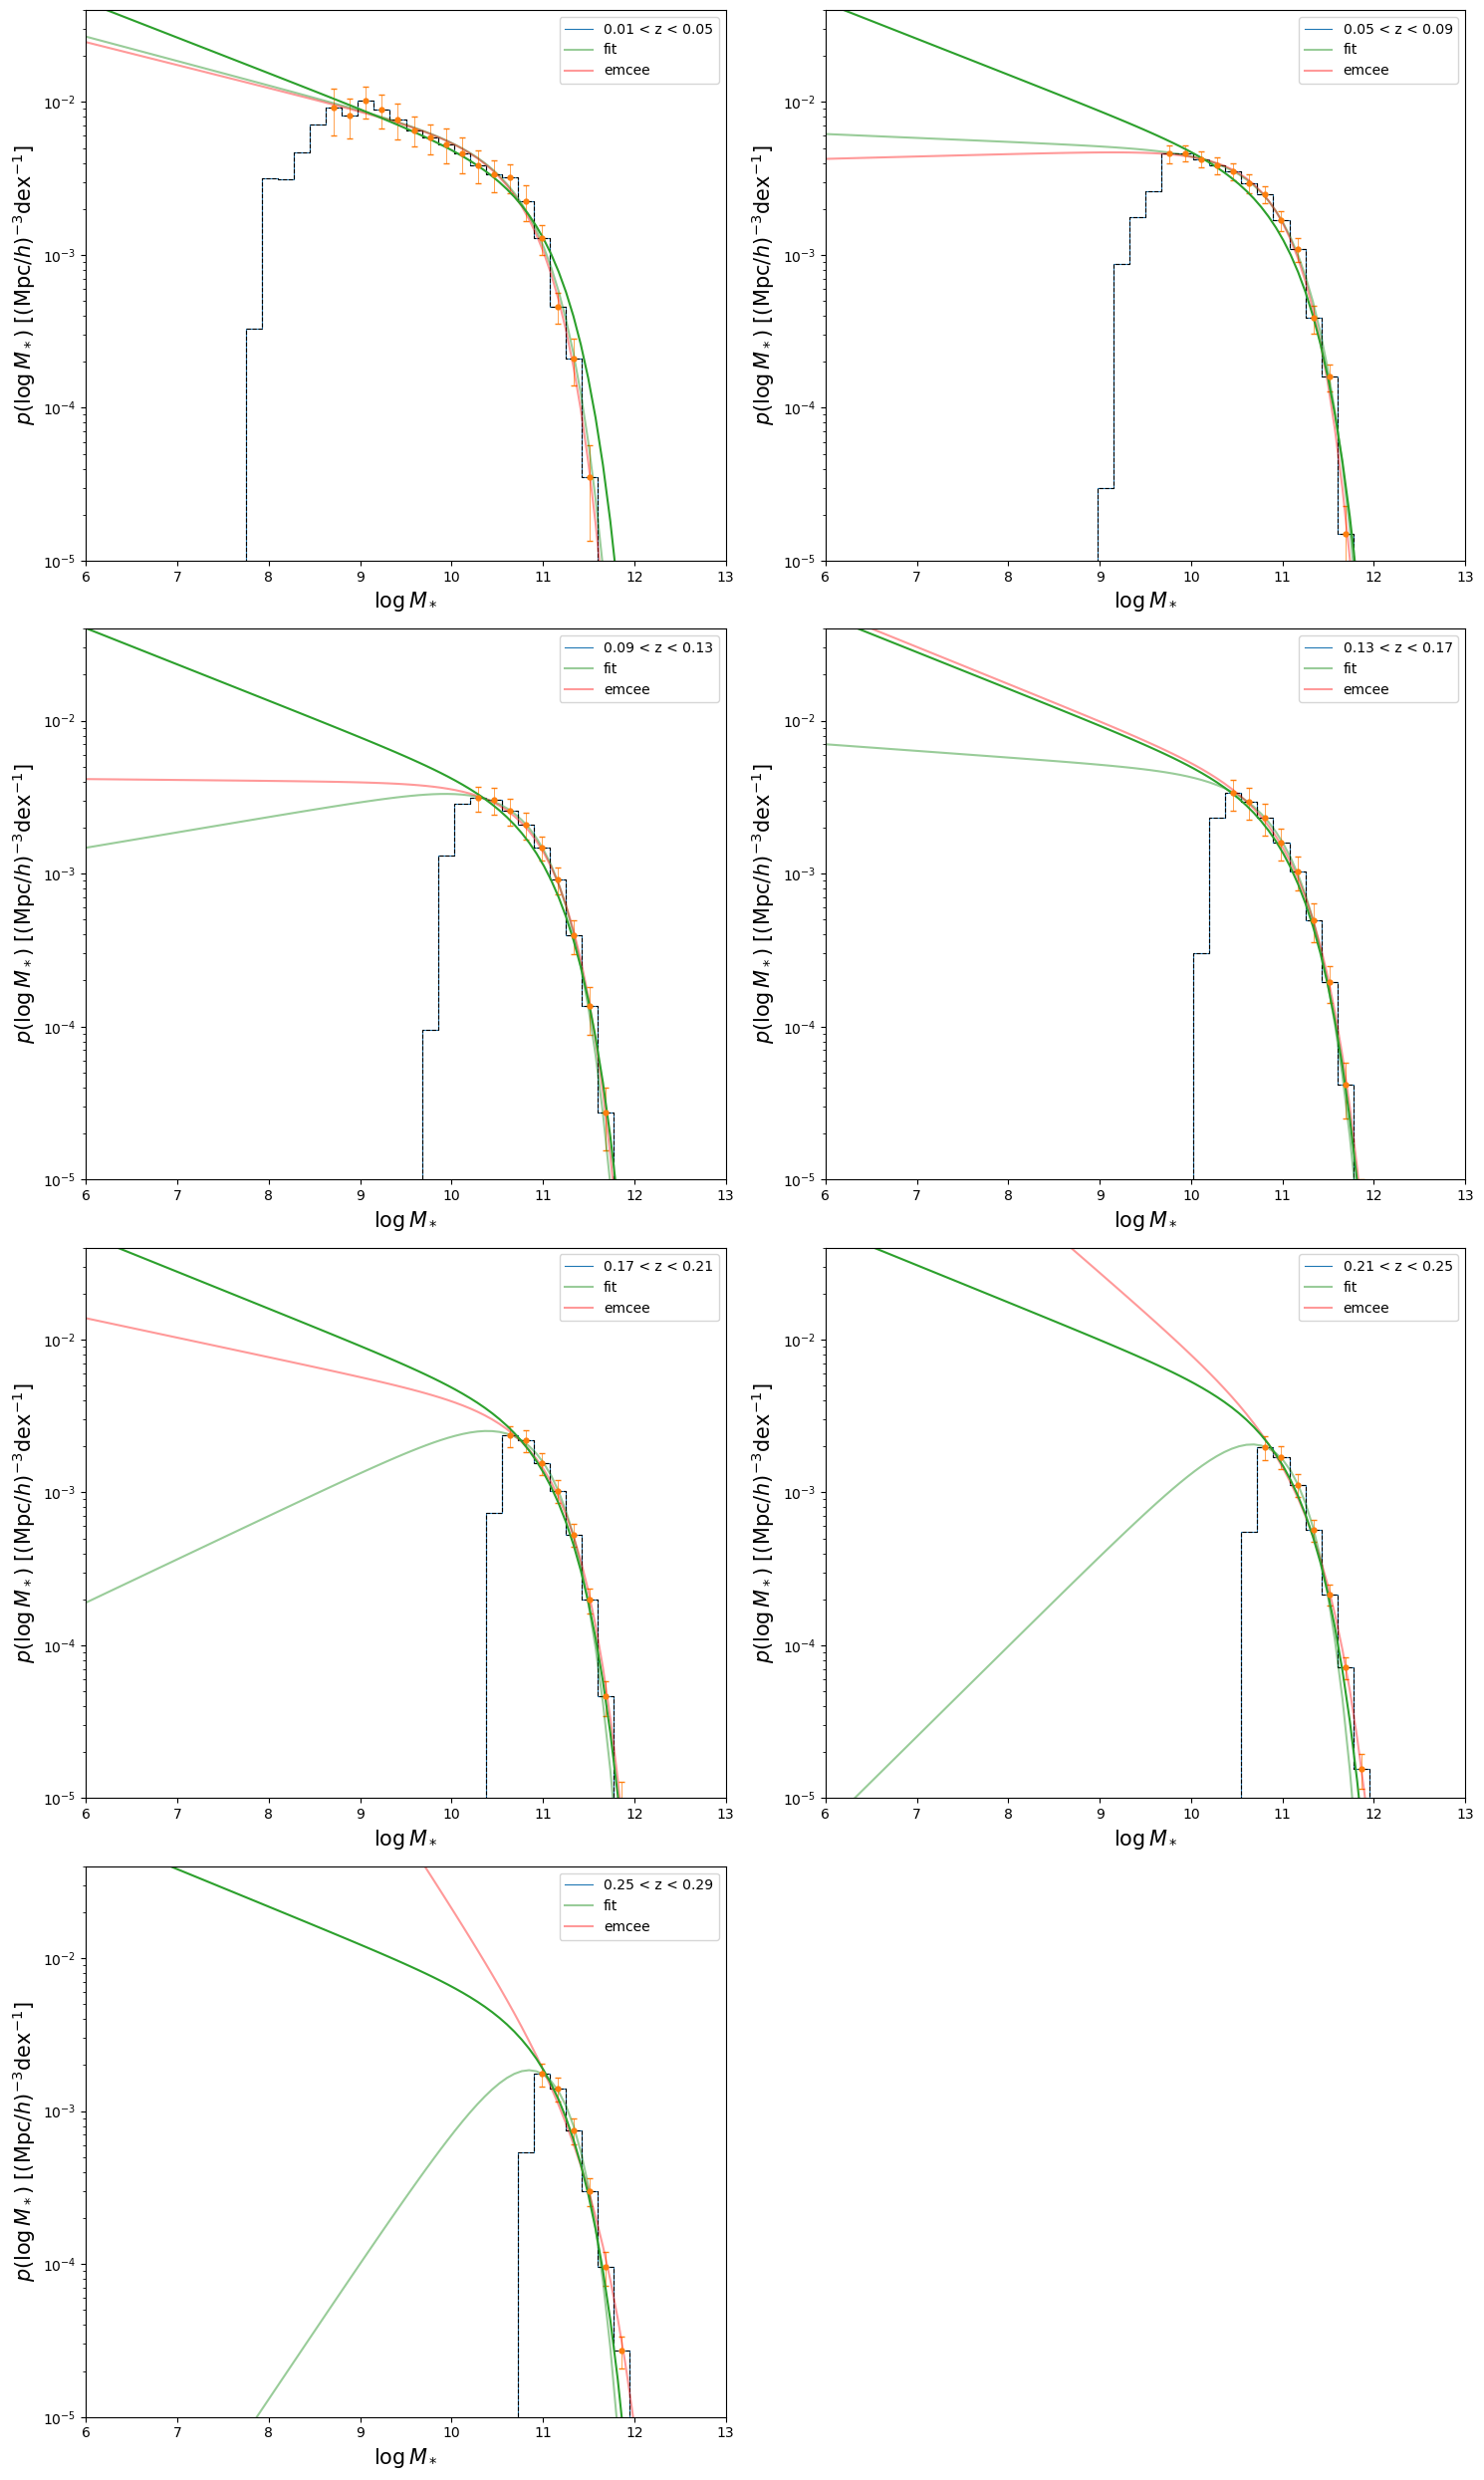

In [13]:
exclude = np.array([5,4,3,2,1,1,1])
x_lin = np.linspace(6, 14, 100)
fit_par = []
sampler_list = []
flat_samples_list = []
mid_bin = []

plt.figure(figsize=(15,25))
for p, zmin, zmax, z0, h, sig_jack, ex in zip(range(0,7),zmins, zmaxs, (zmaxs+zmins)/2, h_tot, sig_jack_tot, exclude):
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    bin_centers = bin_centers[h > 0]
    mid_bin.append(bin_centers)

    plt.subplot(4, 2, p+1)
    Plotter.plot_vmax_hist(h, b, h, b, **{'label':f'{round(zmin,2)} < z < {round(zmax,2)}'})
    plt.errorbar(bin_centers[ex:], h[h>0][ex:], yerr=sig_jack[h>0][ex:], fmt='o', capsize=2, markersize=3.5, elinewidth=0.5)

    popt, _ = curve_fit(fit_schechter, bin_centers[ex:], h[h>0][ex:], p0=[a0 + a1 * z0, a2 + a3 * z0, logPhi_p], maxfev=5000)
    logM, alpha1, logPhi = popt

    emcee_par = run_emcee(bin_centers, h[h>0], sig_jack[h>0], ex, popt, sampler_list, flat_samples_list)
    
    plt.plot(x_lin, fit_schechter(x_lin, logM, alpha1, logPhi), color='green', alpha=0.4, label = 'fit')
    plt.plot(x_lin, fit_schechter(x_lin, emcee_par[0], emcee_par[1], emcee_par[2]), color='red', alpha=0.4, label = 'emcee')
    fit_par.append(popt)

    z, x, x_median, w_spec, vmax = bgs.select_galaxies(zmin, zmax)
    n = normalisation_single(z0, zmin, zmax, x_median, z, best_params)

    plot_zschechter_single(x_lin, z0, n, best_params)
    
    plt.legend(loc='upper right')
plt.tight_layout()

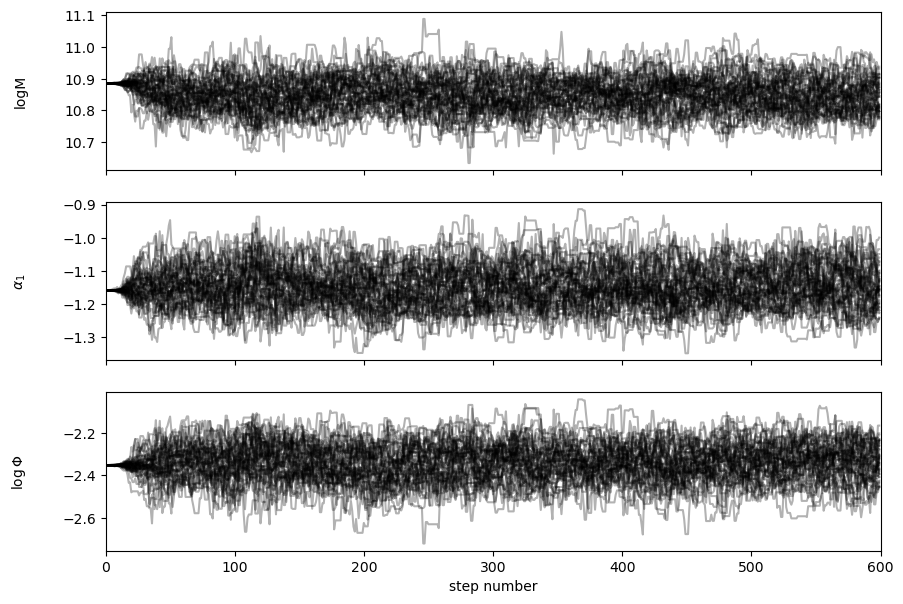

In [14]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler_list[0].get_chain()
labels = [r"logM", r"$\alpha_1$", r"$\log \Phi$"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

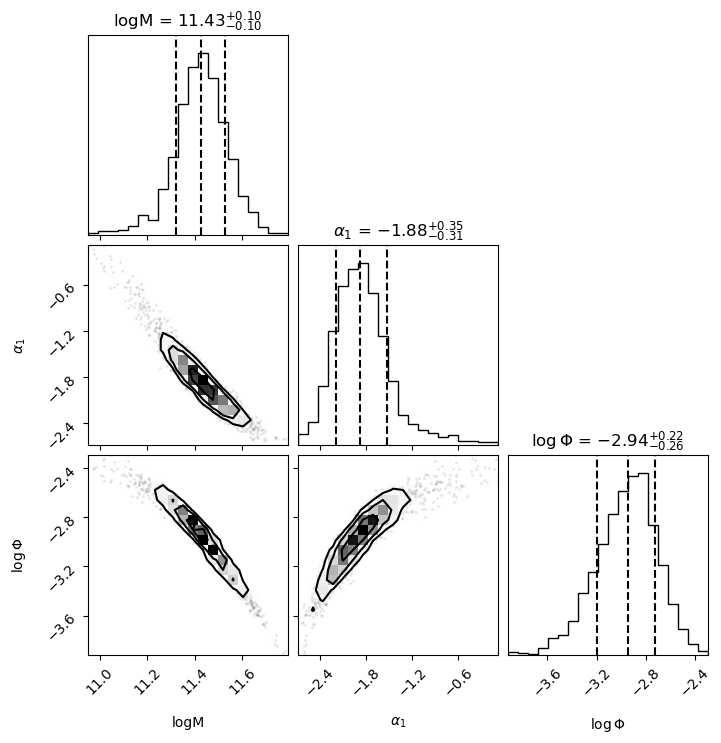

In [15]:
flat_samples = sampler_list[6].get_chain(discard=50, thin=15, flat=True)
import corner

fig = corner.corner(
    flat_samples, labels=labels, quantiles=(0.16, 0.50, 0.84), show_titles=True
);

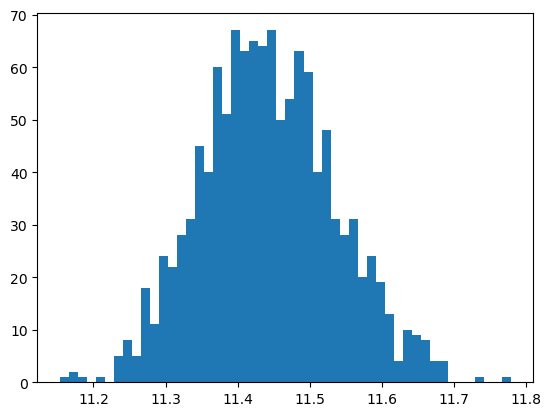

In [16]:
plt.hist(flat_samples_list[6][:,0], bins=50)
plt.show()

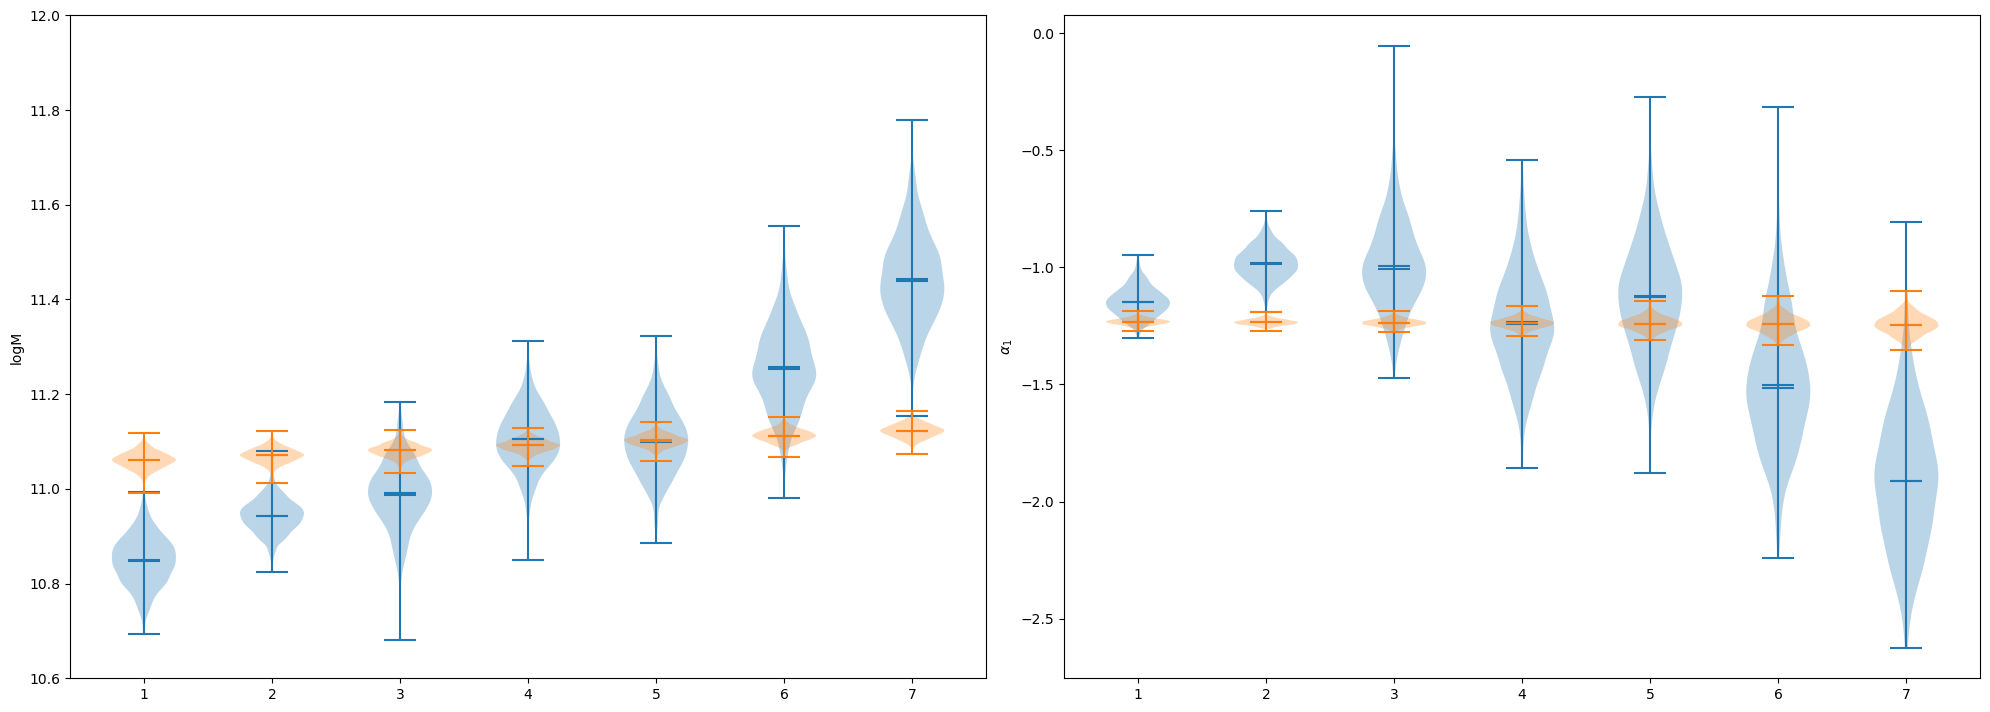

In [17]:
plt.figure(figsize=(20,14))
plt.subplot(2,2,1)
z_lin = np.linspace(0, 0.3, 100)
data_logM = [flat_samples_list[i][:,0] for i in range(7)]
a0_dist = emcee_run.flat_samples[:,0]
a1_dist = emcee_run.flat_samples[:,1]
logM_pSMF = [a0_dist + a1_dist*z0 for z0 in (zmaxs+zmins)/2]

plt.violinplot(data_logM, showmeans=True, showmedians=True)
plt.violinplot(logM_pSMF, showmeans=True, showmedians=True)
# plt.plot(z_lin, a0 + a1 * z_lin)
# plt.plot(np.linspace(0,6,10), 10.6 + 0.2*np.linspace(0,6,10))
plt.ylim(10.6,12)
plt.ylabel('logM')

plt.subplot(2,2,2)
data_alpha1 = [flat_samples_list[i][:,1] for i in range(7)]
a2_dist = emcee_run.flat_samples[:,2]
a3_dist = emcee_run.flat_samples[:,3]
alpha1_pSMF = [a2_dist + a3_dist*z0 for z0 in (zmaxs+zmins)/2]

plt.violinplot(data_alpha1, showmeans=True, showmedians=True)
plt.violinplot(alpha1_pSMF, showmeans=True, showmedians=True)
# plt.plot(z_lin, a2 + a3 * z_lin)
plt.ylabel(r'$\alpha_1$')

plt.tight_layout()
plt.show()

## Convolutions

In [ ]:
Plotter.plot_emcee_corner(emcee_run.flat_samples, emcee_run.labels4)

In [ ]:
a0_dist = emcee_run.flat_samples[:,0]
a1_dist = emcee_run.flat_samples[:,1] * 0.03


In [ ]:
from scipy.stats import gaussian_kde

a0_kde = gaussian_kde(a0_dist)
a1_kde = gaussian_kde(a1_dist)

plt.subplot(1,3,1)
plt.hist(a0_dist, bins=20, density=True)
plt.plot(np.linspace(a0_dist.min(),a0_dist.max(),100), a0_kde(np.linspace(a0_dist.min(),a0_dist.max(),100)))
plt.xlim(a0_dist.min(), a0_dist.max())
plt.xlabel(r'$a_0$')

plt.subplot(1,3,2)
plt.hist(a1_dist, bins=100, density=True)
plt.plot(np.linspace(a1_dist.min(),a1_dist.max(),100), a1_kde(np.linspace(a1_dist.min(),a1_dist.max(),100)))
plt.xlabel(r'$a_1$')

plt.subplot(1,3,3)
# plt.hist(-a1_dist * 0.03 + a0_dist.min(), bins=100)
plt.hist(-a1_dist * 0.03 + 9.5, bins=100)

plt.tight_layout()
plt.show()

In [ ]:
from scipy import signal

big_grid = np.linspace(10.5, 13., 10000)

# conv_pmf = signal.fftconvolve(a0_kde.pdf(big_grid) , a1_kde.pdf(big_grid - a0_dist) ,'same') 

In [ ]:
def conv(x, y, kde1, kde2):
    return kde1.pdf(x) * kde2.pdf(y-x)

In [ ]:
logM_dist = []
for y in big_grid:
    logM_dist.append(integrate.quad(conv, 10.5,13, args=(y, a0_kde, a1_kde))[0])

In [ ]:
logM_003_dist = np.array(logM_dist)

In [ ]:
logM_003_dist[logM_003_dist > 0]

In [ ]:
plt.plot(big_grid, logM_003_dist)
plt.xlim(10.8, 11.3)

In [ ]:
plt.hist(a0_dist + a1_dist, bins=100)
plt.show

In [ ]:
integrate.quad(a0_kde.pdf*a1_kde.pdf)

In [ ]:
plt.plot(big_grid,conv_pmf)

In [ ]:
np.histogram(a0_dist, bins=100), np.histogram(-a1_dist * 0.03 + 9, bins=100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate some sample data
np.random.seed(42)
data = np.concatenate([np.random.normal(0, 1, 500), np.random.normal(5, 2, 500)])

# Perform KDE
kde = gaussian_kde(data)


# Generate a range of values for plotting
x_values = np.linspace(min(data), max(data), 1000)

# Plot the original data and KDE
plt.hist(data, bins=30, alpha=0.5, weights=np.repeat(1/data.shape[0], data.shape[0]), label='Original Data')
plt.plot(x_values, kde(x_values)*0.45, label='KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()




# Sample from the KDE
num_samples = 1000
samples_from_kde = kde.resample(size=num_samples)

# Introduce some randomness to the resampled values
random_noise = np.random.normal(0, 0.1, num_samples)
samples_from_kde_with_noise = samples_from_kde + random_noise

# Compute histogram
hist, bin_edges = np.histogram(samples_from_kde_with_noise, bins=30, density=True)

# Plot the histogram
plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0], alpha=0.5, label='Histogram of Samples from KDE with Noise')
plt.plot(x_values, kde(x_values), label='KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [ ]:
samples_from_kde

In [ ]:
np.histogram(data, bins=30), +3.24126734 - 2.79106629